In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# Loading data

In [2]:
df = pd.read_csv('Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv', low_memory = False)

In [3]:
print(df.shape)

print(df.columns)

# display the current dataframe
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
df.head(1)

(170366, 79)
Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,389,113095465,48,24,9668,10012,403,0,201.416667,203.548293,923,316,417.166667,231.080951,174.012282,0.63663,1592893.873,4597264.595,16500000,3,113000000,2406286.489,5491986.114,16500000,3,113000000,4917177.522,7084368.263,16500000,3,1,0,0,0,1536,768,0.42442,0.21221,0,923,275.109589,233.833248,54677.98782,0,1,0,0,1,0,0,0,0,278.930556,201.416667,417.166667,1536,0,0,0,0,0,0,48,9668,24,10012,571,2079,23,32,203985.5,575837.2562,1629110,379,13800000.0,4277541.062,16500000,6737603,BENIGN


# Data preprocessing

In [4]:
#change the variable types for low memory usage
#int64 to int32,,, float64 to float32
integer = []
f = []
for i in df.columns[:-1]:
    if df[i].dtype == "int64": integer.append(i)
    else : f.append(i)

df[integer] = df[integer].astype("int32")
df[f] = df[f].astype("float32")

In [5]:
# Remove leading whitespaces in column names
df.columns =  df.columns.str.strip()
# drop nan and infinite rows
df = df[~df.isin([np.nan, np.inf, -np.inf]).any(axis=1)]
print(df.shape)

(170231, 79)


In [6]:
# analyze and decompose the "destination port" column
print (df['Destination Port'].value_counts())

port_53 = []
port_443 = []
port_80 = []
port_123 = []
port_22 = []

for data in df["Destination Port"]:
  if (data == 53):
    port_53.append(1)
    port_443.append(0)
    port_80.append(0)
    port_123.append(0)
    port_22.append(0)
  elif (data == 443):
    port_53.append(0)
    port_443.append(1)
    port_80.append(0)
    port_123.append(0)
    port_22.append(0)
  elif (data == 80):
    port_53.append(0)
    port_443.append(0)
    port_80.append(1)
    port_123.append(0)
    port_22.append(0)
  elif (data == 123):
    port_53.append(0)
    port_443.append(0)
    port_80.append(0)
    port_123.append(1)
    port_22.append(0)
  elif (data == 22):
    port_53.append(0)
    port_443.append(0)
    port_80.append(0)
    port_123.append(0)
    port_22.append(1)
  else:
    port_53.append(0)
    port_443.append(0)
    port_80.append(0)
    port_123.append(0)
    port_22.append(0)

df["port_53"] = port_53
df["port_443"] = port_443
df["port_80"] = port_80
df["port_123"] = port_123
df["port_22"] = port_22

cols = df.columns.tolist()
cols = cols[-5:] + cols[:-5]
df = df[cols]

print('\n', df.columns)

print('\n', df.shape)

53       76545
443      35806
80       20837
123       3746
22        1035
         ...  
2600         1
59110        1
45764        1
2606         1
60146        1
Name: Destination Port, Length: 17764, dtype: int64

 Index(['port_53', 'port_443', 'port_80', 'port_123', 'port_22',
       'Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
   

In [7]:
# # merging similar classes with low instances
# df["Label"] = df["Label"].replace(["Web Attack: Brute Force","Web Attack: XSS","Web Attack: Sql Injection"],"Web Attack")

# drop duplicate rows
df =  df.drop_duplicates(keep="first")
df.reset_index(drop=True,inplace=True)
print(df.shape)

(164179, 84)


In [8]:
X = df.drop(["Label"],axis=1)
y = df["Label"]
print(X.shape)

(164179, 83)


# Features Selection

In [9]:
# remove columns with only 1 unique value
cols_to_drop = X.nunique()
cols_to_drop = cols_to_drop.loc[cols_to_drop.values==1].index
X = X.drop(cols_to_drop,axis=1)
print(X.shape)

(164179, 73)


## Correlation based Feature Selection

<Axes: >

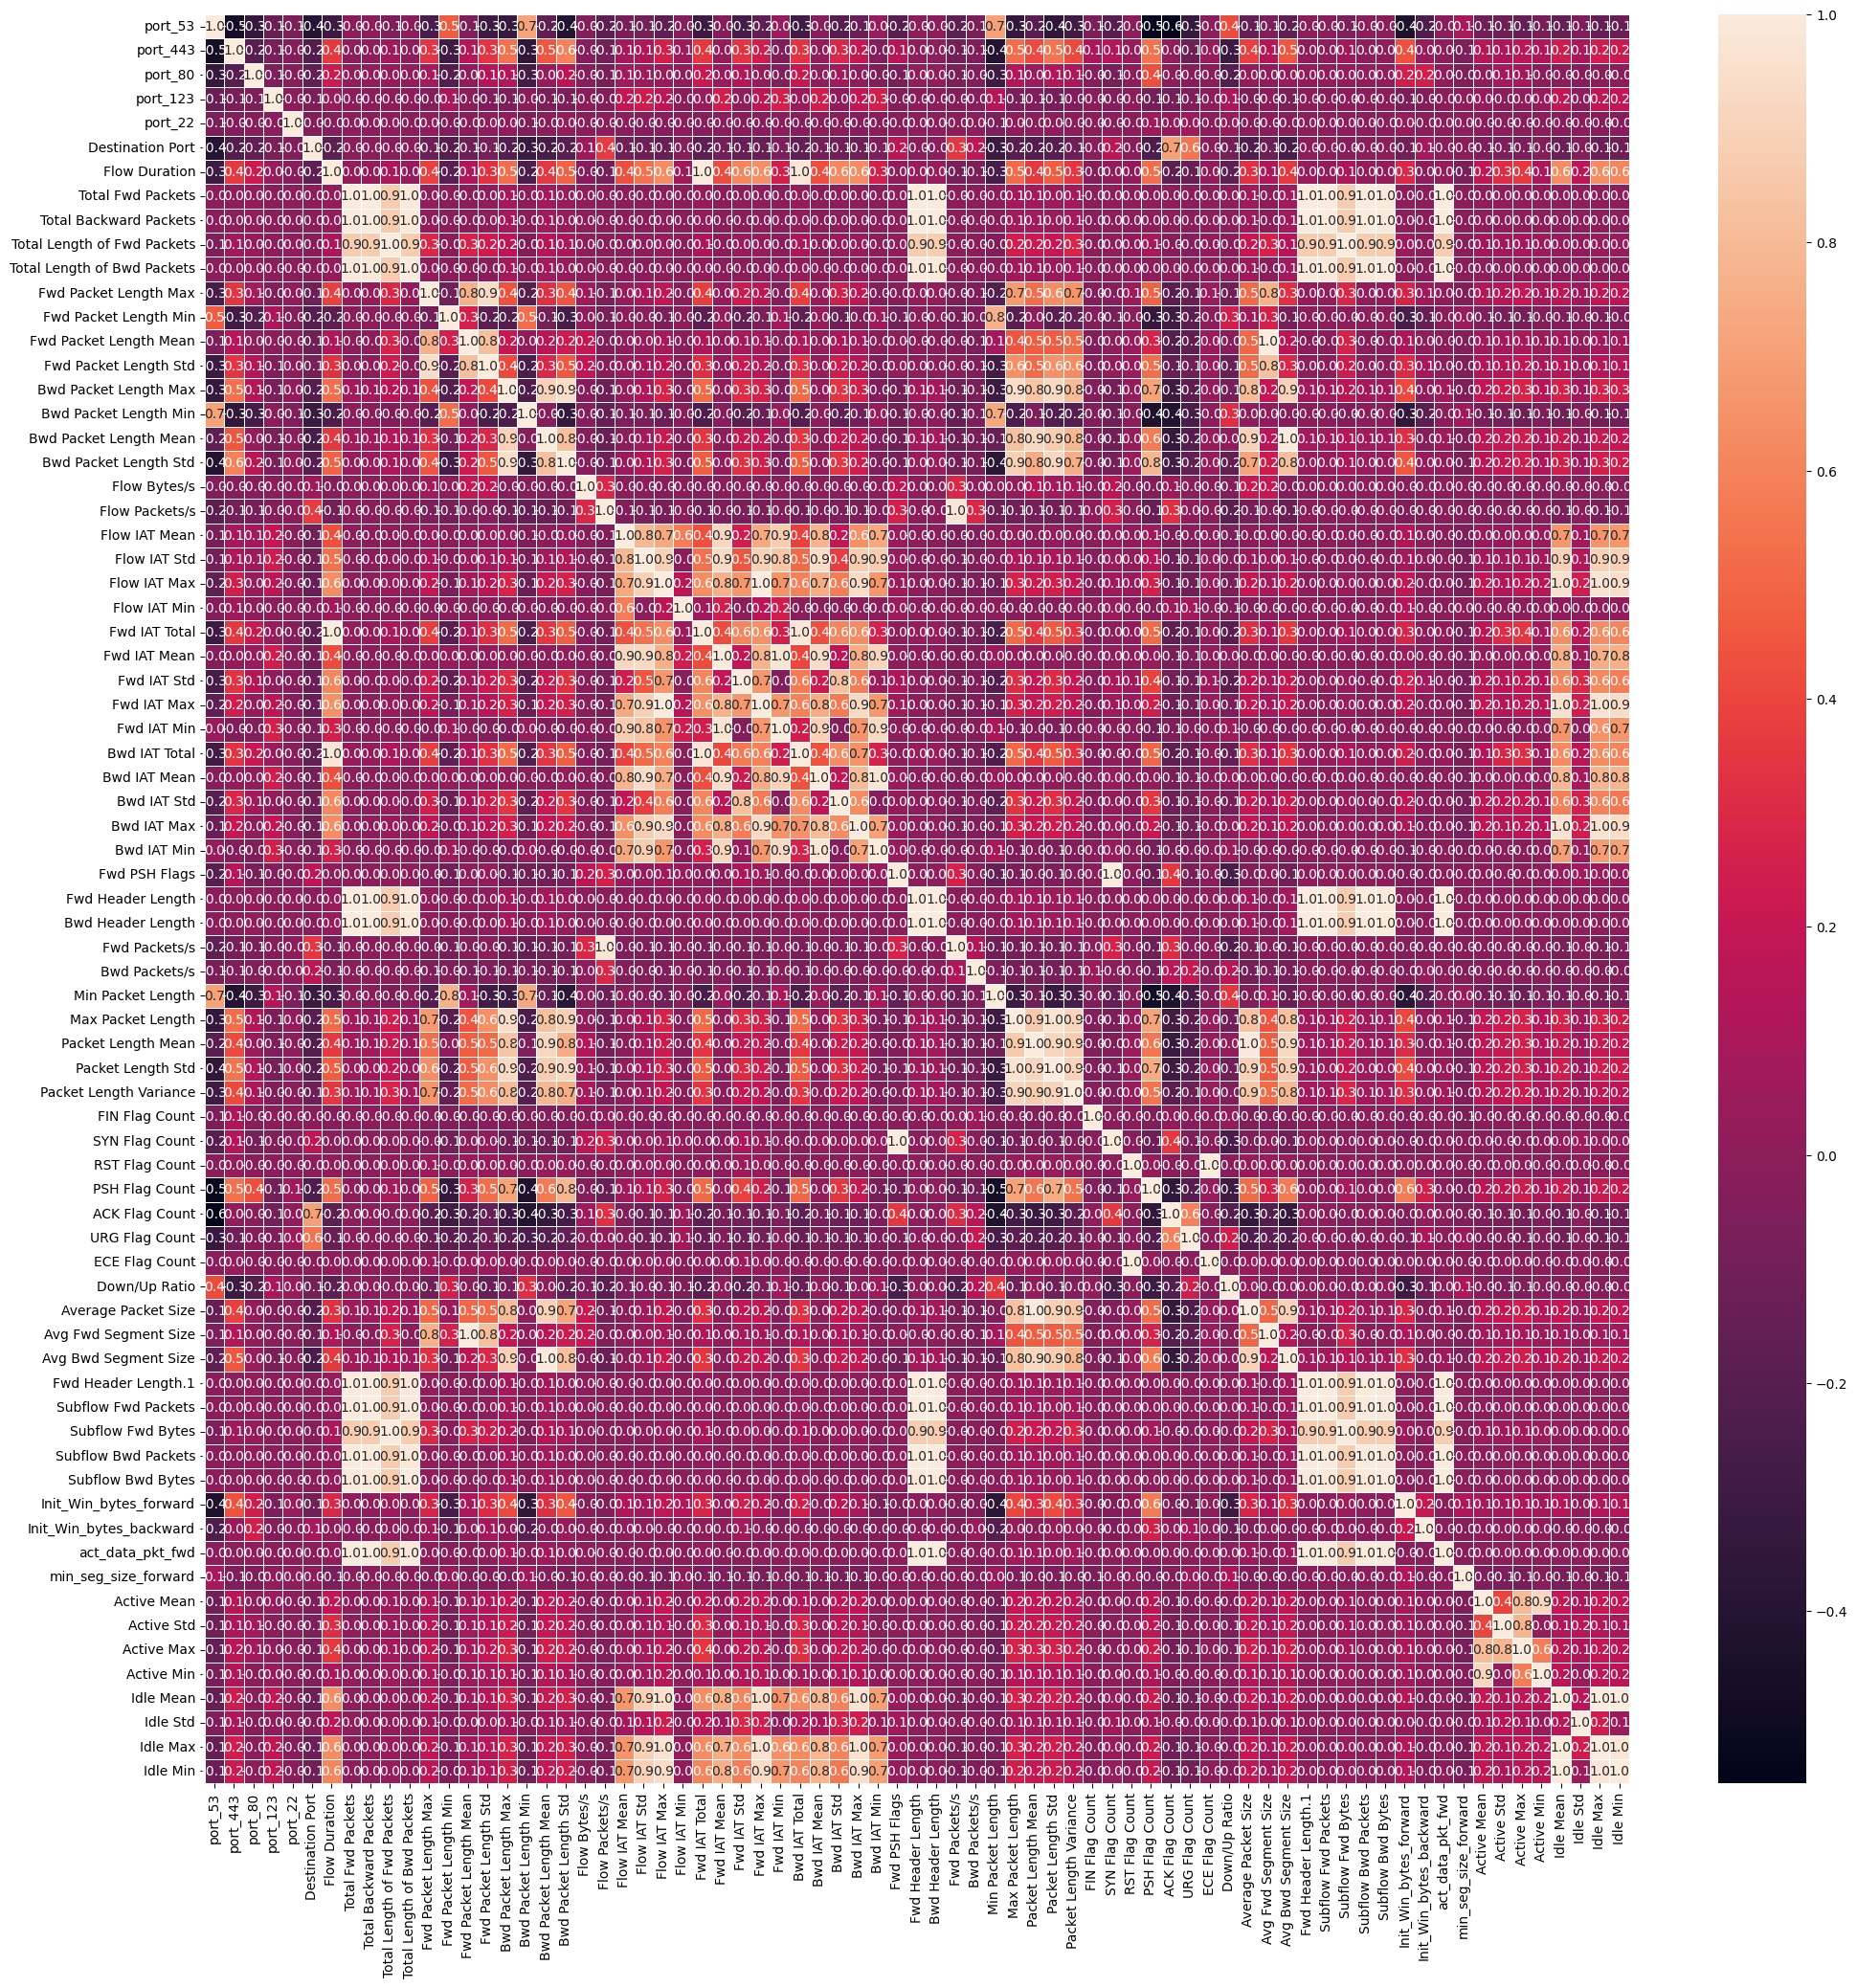

In [10]:
# features correlation heatmap
f,ax = plt.subplots(figsize=(24, 24))
corr = X.corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [11]:
#feature reduction
#dropping very high correlated features
numeric_columns = X.select_dtypes(include=[np.number])

corr_matrix = numeric_columns.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

# Drop features
X =  X.drop(to_drop, axis=1)


<ipython-input-11-1f3462962584>:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


(164179, 34)
Index(['port_53', 'port_443', 'port_80', 'port_123', 'port_22',
       'Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Std',
       'Fwd PSH Flags', 'Bwd Packets/s', 'Min Packet Length', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Active Mean', 'Active Std', 'Idle Std'],
      dtype='object')


<Axes: >

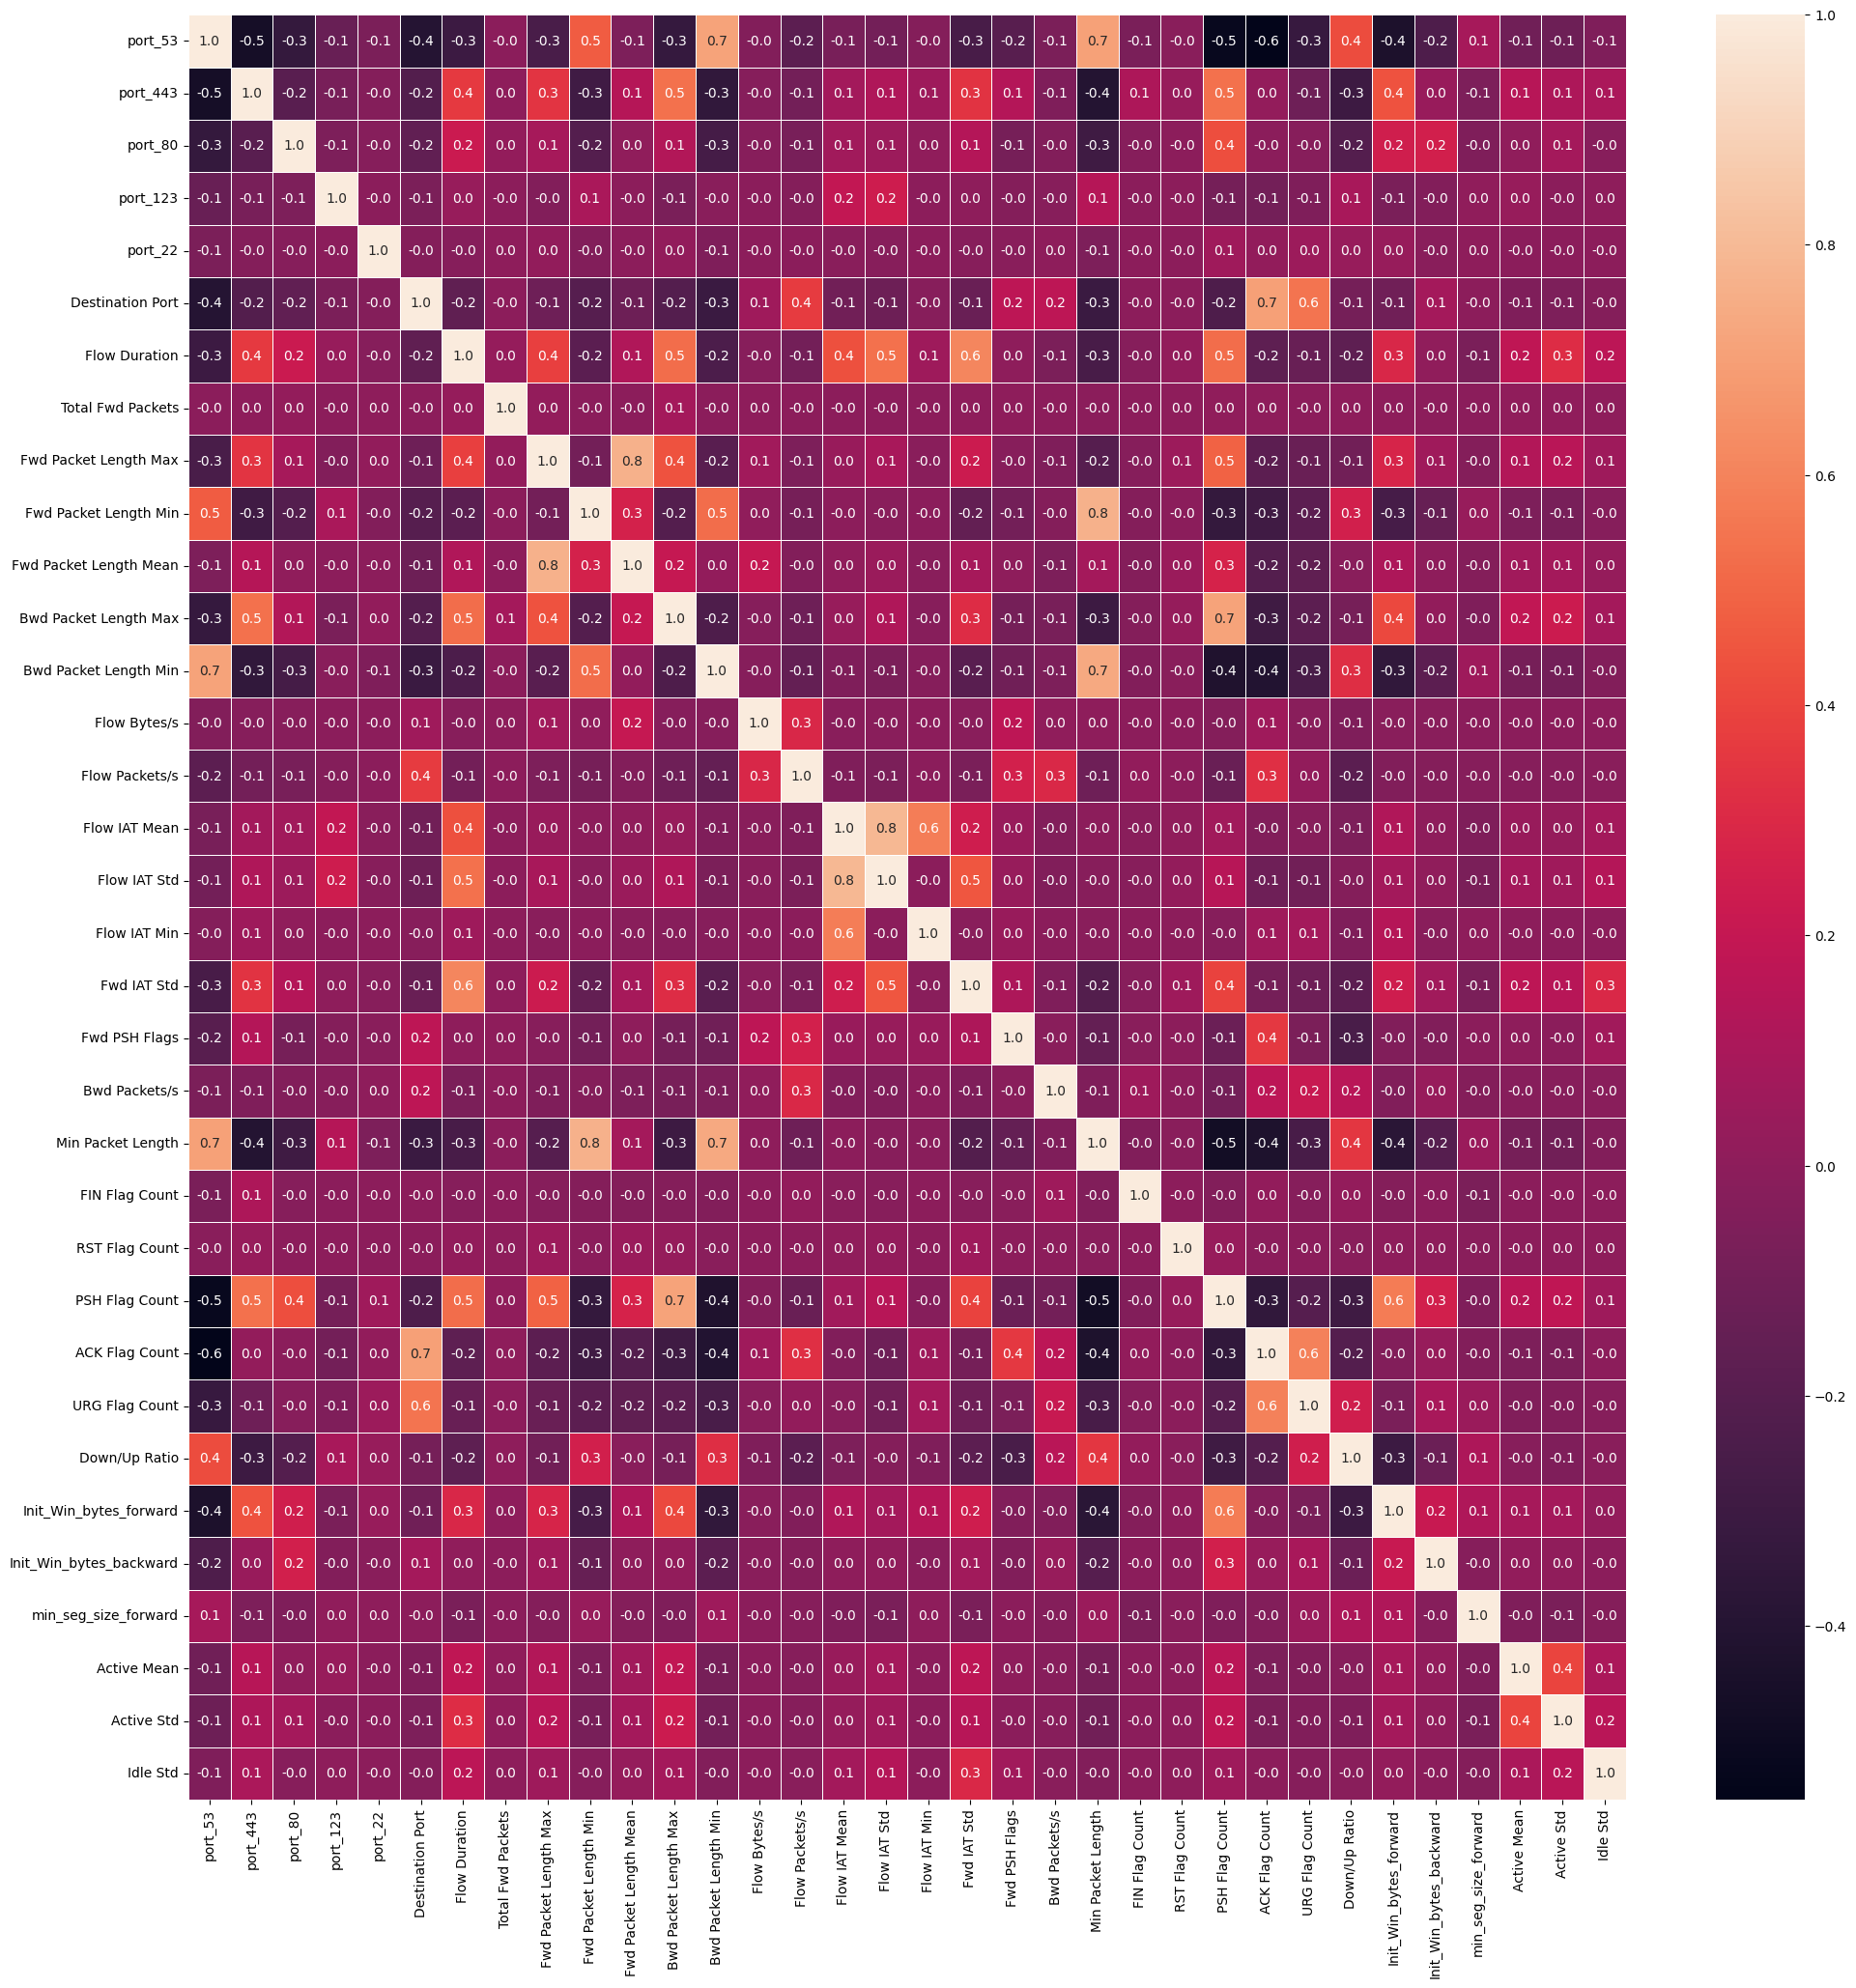

In [12]:
print(X.shape)

print(X.columns)

# features correlation heatmap
f,ax = plt.subplots(figsize=(24, 24))
corr = X.corr()
sns.heatmap(corr, annot=True, linewidths=.5, fmt= '.1f',ax=ax)

## Recursive Feature Elimination

In [13]:
from sklearn.preprocessing import LabelEncoder

X2 = X.copy()
y2 = y.copy()

# Create an instance of LabelEncoder
label_encoder = LabelEncoder()

# Encode the categorical labels in y
encoded_labels = label_encoder.fit_transform(y2)

# Check the distribution of classes in encoded_labels
class_counts = np.bincount(encoded_labels)
min_class_count = np.min(class_counts)

#Feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(X2, y2);

# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':X2.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')


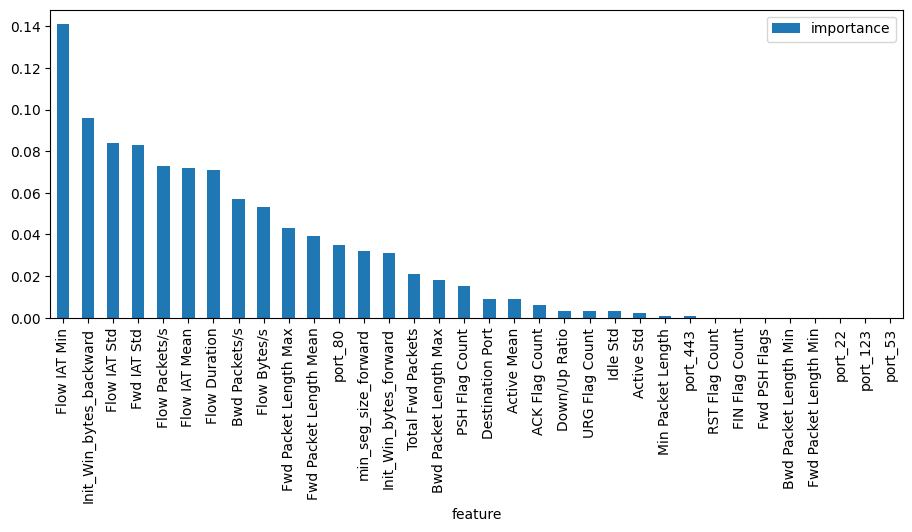

In [14]:
# plot importances
default_figsize = plt.rcParams['figure.figsize']
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar()
plt.rcParams['figure.figsize'] = default_figsize

In [15]:
#Recursive feature elimination
from sklearn.feature_selection import RFE
import itertools

rfc = RandomForestClassifier()

# create the RFE model and select 34 attributes
rfe = RFE(rfc, n_features_to_select=34)
rfe = rfe.fit(X2, y2)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.zip_longest(rfe.get_support(), X2.columns)]
selected_features = [v for i, v in feature_map if i==True]

# print(selected_features)

a = [i[0] for i in feature_map]
X2 = X2.iloc[:,a]

print(X2.shape)
print(X2.columns)

(164179, 34)
Index(['port_53', 'port_443', 'port_80', 'port_123', 'port_22',
       'Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Min', 'Fwd IAT Std',
       'Fwd PSH Flags', 'Bwd Packets/s', 'Min Packet Length', 'FIN Flag Count',
       'RST Flag Count', 'PSH Flag Count', 'ACK Flag Count', 'URG Flag Count',
       'Down/Up Ratio', 'Init_Win_bytes_forward', 'Init_Win_bytes_backward',
       'min_seg_size_forward', 'Active Mean', 'Active Std', 'Idle Std'],
      dtype='object')


# Oversampling

Counter({'BENIGN': 162036, 'Web Attack � Brute Force': 1470, 'Web Attack � XSS': 652, 'Web Attack � Sql Injection': 21})


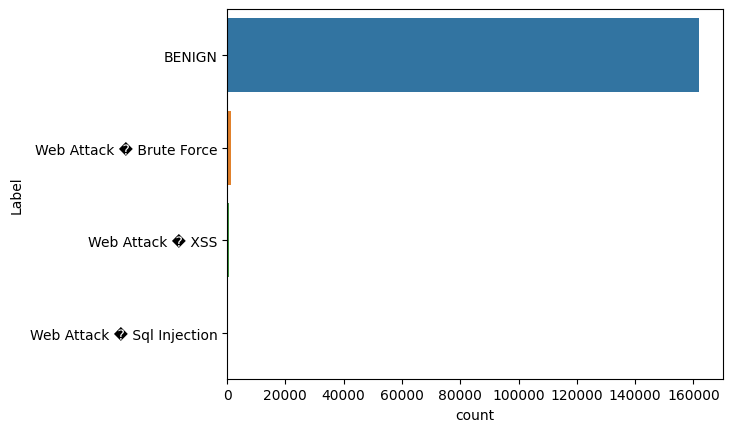

In [16]:
counter = Counter(y)
print(counter)

ax = sns.countplot(y = y)

Counter({'BENIGN': 162036, 'Web Attack � Brute Force': 50000, 'Web Attack � XSS': 50000, 'Web Attack � Sql Injection': 50000})


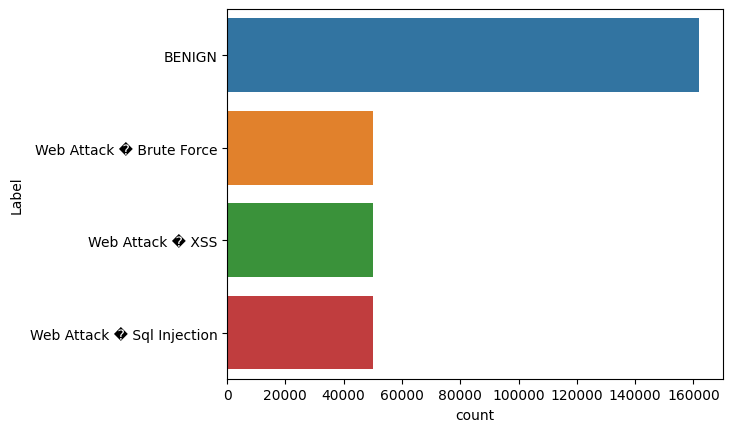

In [17]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy={'Web Attack � Brute Force': 50000, 'Web Attack � XSS': 50000, 'Web Attack � Sql Injection': 50000})
X_o, y_o = oversample.fit_resample(X, y)

counter = Counter(y_o)
print(counter)

ax = sns.countplot(y = y_o)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_o, y_o, train_size=0.8, test_size=0.2, stratify=y_o)
print(X_train.shape)

(249628, 34)


# Models fitting

## Logistic Regression

In [19]:
x_axis_labels = ['BENIGN', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']
y_axis_labels = ['BENIGN', 'Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 


Cross-Validation Score: 0.6282508322031177 

                            precision    recall  f1-score   support

                    BENIGN       0.72      0.92      0.81     32408
  Web Attack � Brute Force       0.01      0.00      0.00     10000
Web Attack � Sql Injection       0.00      0.00      0.00     10000
          Web Attack � XSS       0.45      0.93      0.60     10000

                  accuracy                           0.63     62408
                 macro avg       0.29      0.46      0.35     62408
              weighted avg       0.45      0.63      0.52     62408



<Axes: >

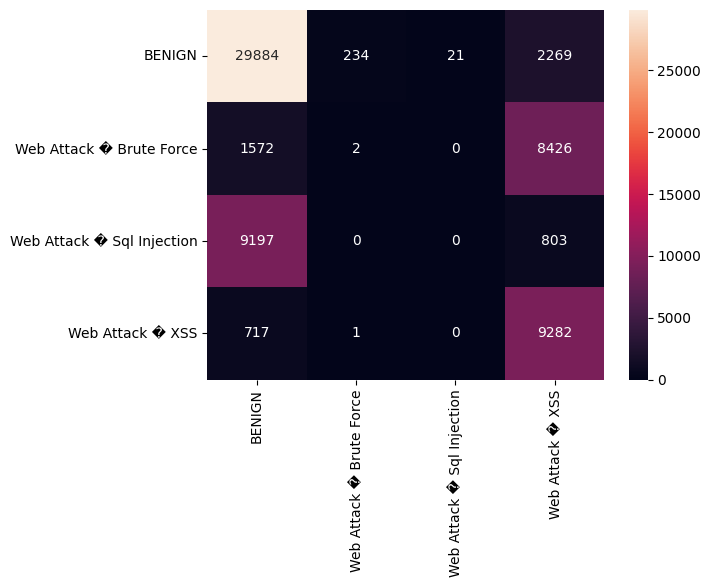

In [20]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression(solver='saga')
model_1.fit(X_train, y_train)

print("\nCross-Validation Score:", cross_val_score(model_1, X_train, y_train).mean(), '\n')

y_pred = model_1.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

## Gradient Boosting Machines


Cross-Validation Score: 0.880958861598892 

                            precision    recall  f1-score   support

                    BENIGN       1.00      0.99      0.99     32408
  Web Attack � Brute Force       0.72      0.46      0.56     10000
Web Attack � Sql Injection       0.96      1.00      0.98     10000
          Web Attack � XSS       0.62      0.82      0.70     10000

                  accuracy                           0.88     62408
                 macro avg       0.82      0.82      0.81     62408
              weighted avg       0.88      0.88      0.88     62408



<Axes: >

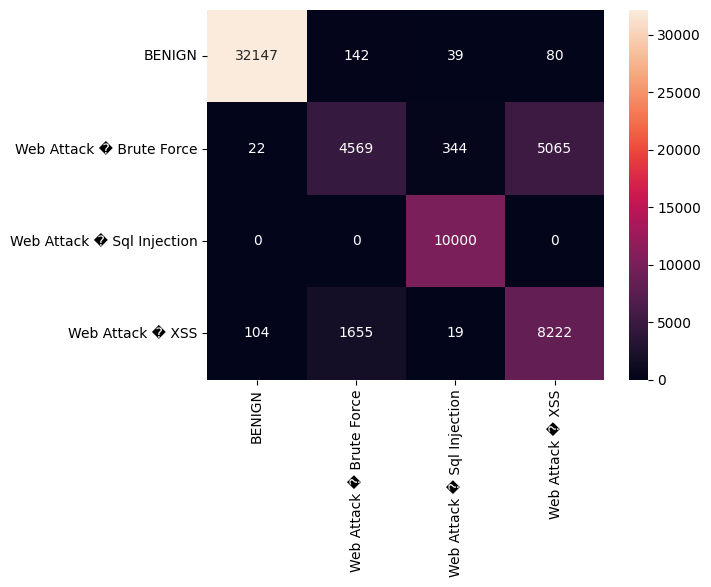

In [21]:
from lightgbm import LGBMClassifier

model_2 = LGBMClassifier(
    max_depth=3,
    learning_rate=0.01,
    n_estimators=200,
    objective='multiclass',
    num_class=4,
    boosting_type='gbdt',
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1
)
model_2.fit(X_train, y_train)

print("\nCross-Validation Score:", cross_val_score(model_2, X_train, y_train).mean(), '\n')

y_pred = model_2.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

### Features importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

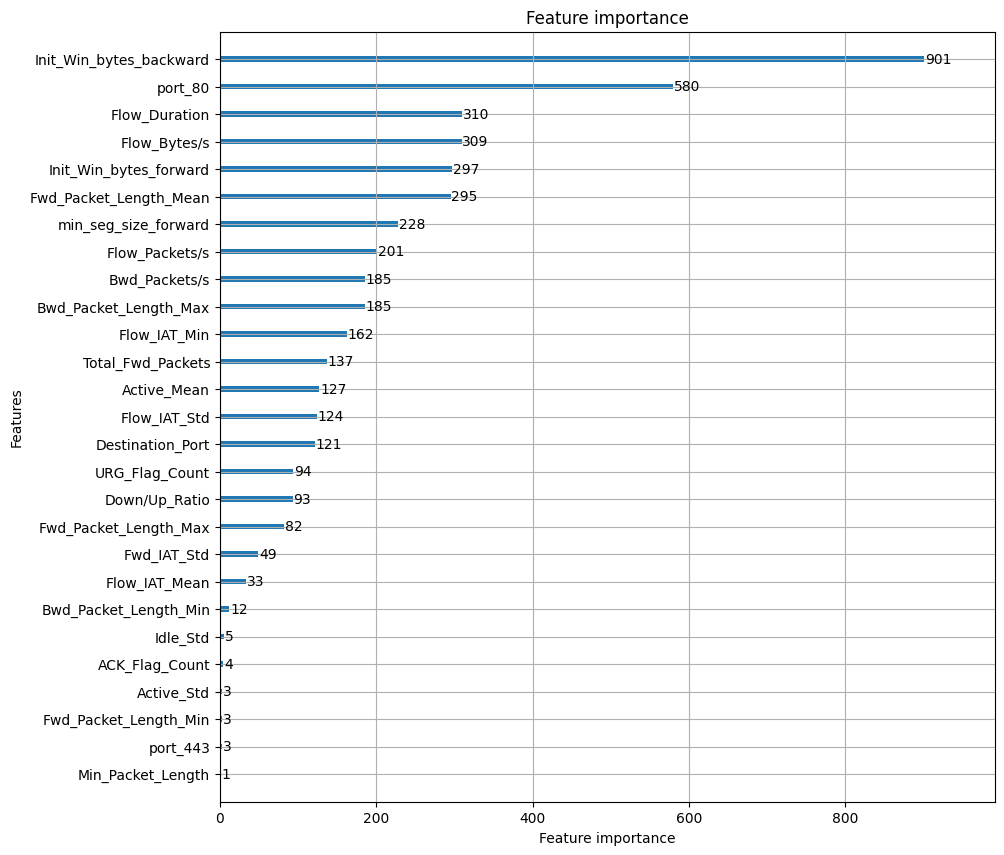

In [22]:
from lightgbm import plot_importance, plot_split_value_histogram

fig,ax = plt.subplots(1,1,figsize=(10,10))
plot_importance(booster=model_2, ax=ax, max_num_features=30)

### Parameters Tuning by GridSearchCV

In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {
              'max_depth': [1, 3, 10, 20, 30],
              'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15]
}

gsearch = GridSearchCV(model_2, param_grid=parameters, scoring='accuracy', cv=3)
gsearch.fit(X_train, y_train)

print("Best score: %0.3f\n" % gsearch.best_score_)
print("Best parameters set:")
best_parameters = gsearch.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Best score: 0.950

Best parameters set:
	learning_rate: 0.15
	max_depth: 30



Cross-Validation Score: 0.9500496677797212 

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     32408
  Web Attack � Brute Force       0.87      0.81      0.84     10000
Web Attack � Sql Injection       1.00      1.00      1.00     10000
          Web Attack � XSS       0.82      0.88      0.85     10000

                  accuracy                           0.95     62408
                 macro avg       0.92      0.92      0.92     62408
              weighted avg       0.95      0.95      0.95     62408



<Axes: >

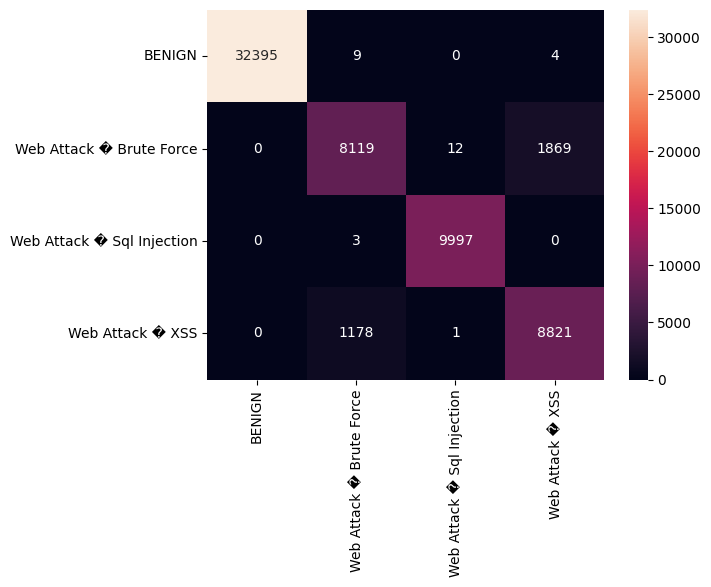

In [24]:
model_2_2 = LGBMClassifier(
    max_depth=20,
    learning_rate=0.15,
    n_estimators=200,
    objective='multiclass',
    num_class=4,
    boosting_type='gbdt',
    min_child_weight=2,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1
)
model_2_2.fit(X_train, y_train)

print("\nCross-Validation Score:", cross_val_score(model_2_2, X_train, y_train).mean(), '\n')

y_pred = model_2_2.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

## Decision Tree


Cross-Validation Score: 0.9754234218771975 

                            precision    recall  f1-score   support

                    BENIGN       1.00      1.00      1.00     32408
  Web Attack � Brute Force       0.93      0.92      0.93     10000
Web Attack � Sql Injection       1.00      1.00      1.00     10000
          Web Attack � XSS       0.93      0.94      0.93     10000

                  accuracy                           0.98     62408
                 macro avg       0.96      0.97      0.96     62408
              weighted avg       0.98      0.98      0.98     62408



<Axes: >

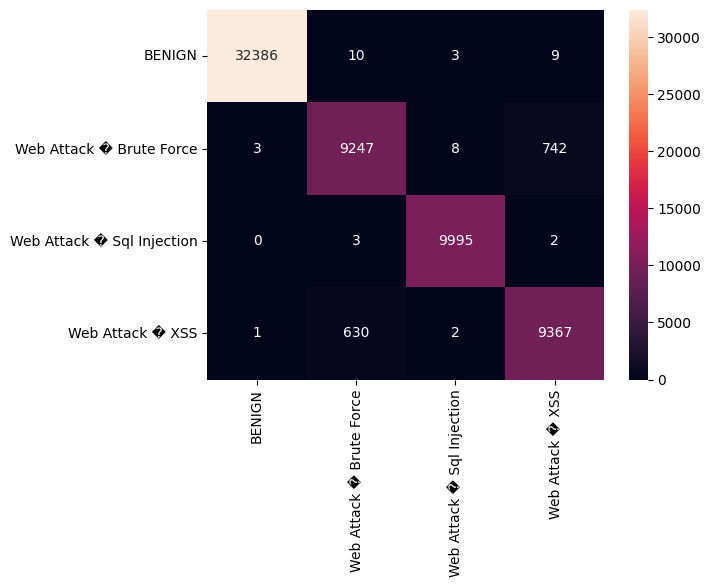

In [25]:
from sklearn.tree import DecisionTreeClassifier

model_3 = DecisionTreeClassifier()
model_3.fit(X_train, y_train)

print("\nCross-Validation Score:", cross_val_score(model_3, X_train, y_train).mean(), '\n')

y_pred = model_3.predict(X_test)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=x_axis_labels, yticklabels=y_axis_labels)